In [45]:
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt


In [46]:
# Load preprocessed CSVs
X_train = pd.read_csv("data/processed/X_train_res.csv")
y_train = pd.read_csv("data/processed/y_train_res.csv").squeeze()
X_test = pd.read_csv("data/processed/X_test.csv")
y_test = pd.read_csv("data/processed/y_test.csv").squeeze()

# Adjust labels if needed (e.g., convert from [1,2,3] → [0,1,2])
y_train = y_train - 1
y_test = y_test - 1

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Train class distribution:\n", y_train.value_counts())

rf_best = joblib.load("models/random_forest.joblib")
xgb_best = joblib.load("models/xgboost.joblib")

(3978, 21) (3978,) (426, 21) (426,)
Train class distribution:
 NSP
2.0    1326
0.0    1326
1.0    1326
Name: count, dtype: int64


In [47]:
# Soft voting uses predicted probabilities → more stable for unbalanced data
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

y_pred_vote = voting_clf.predict(X_test)

In [48]:
def clip_probs(X):
    return np.clip(X, 1e-6, 1 - 1e-6)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    final_estimator=make_pipeline(
        FunctionTransformer(clip_probs),
        StandardScaler(),
        LogisticRegression(max_iter=2000, solver='lbfgs')
    ),
    stack_method='predict_proba',
    passthrough=False
)


In [49]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f} | F1 (macro): {f1:.4f} | Recall (macro): {recall:.4f}")
    print(classification_report(y_true, y_pred, digits=3))
    return acc, f1, recall

metrics = {}
metrics['Voting Ensemble'] = evaluate_model("Voting Ensemble", y_test, y_pred_vote)
metrics['Stacking Ensemble'] = evaluate_model("Stacking Ensemble", y_test, y_pred_stack)


Voting Ensemble Results:
Accuracy: 0.9460 | F1 (macro): 0.9020 | Recall (macro): 0.8910
              precision    recall  f1-score   support

         0.0      0.962     0.979     0.970       332
         1.0      0.868     0.780     0.821        59
         2.0      0.914     0.914     0.914        35

    accuracy                          0.946       426
   macro avg      0.915     0.891     0.902       426
weighted avg      0.945     0.946     0.945       426


Stacking Ensemble Results:
Accuracy: 0.9413 | F1 (macro): 0.8903 | Recall (macro): 0.8758
              precision    recall  f1-score   support

         0.0      0.959     0.979     0.969       332
         1.0      0.849     0.763     0.804        59
         2.0      0.912     0.886     0.899        35

    accuracy                          0.941       426
   macro avg      0.907     0.876     0.890       426
weighted avg      0.940     0.941     0.940       426




Overall Comparison:
                    Accuracy  F1_macro  Recall_macro
Voting Ensemble    0.946009  0.901955      0.890954
Stacking Ensemble  0.941315  0.890275      0.875781


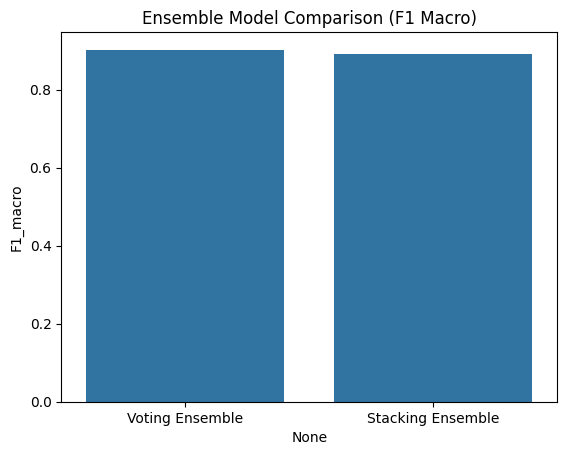

In [50]:
metrics_df = pd.DataFrame(metrics, index=["Accuracy", "F1_macro", "Recall_macro"]).T
print("\nOverall Comparison:\n", metrics_df)

sns.barplot(data=metrics_df, x=metrics_df.index, y="F1_macro")
plt.title("Ensemble Model Comparison (F1 Macro)")
plt.show()

In [ ]:
os.makedirs("models", exist_ok=True)
joblib.dump(voting_clf, "models/best_voting_ensemble.joblib")
joblib.dump(stacking_clf, "models/best_stacking_ensemble.joblib")
print("\n Ensembles completed and models saved")


Ensembles completed and models saved.
